In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
path_to_data = '/Users/janbraunsdorff/Studienarbeit-projekt/data'
path_to_validation_annotation = path_to_data + "/validation.csv"
path_to_training_annotation = path_to_data + "/training.csv"
path_to_validatoin_data = path_to_data + '/boneage-validation-dataset/'
path_to_training_data = path_to_data + '/boneage-training-dataset/'
path = path_to_data + '/pickel/v3'

In [3]:
def p1(img, resize_to=500):
    img = cv2.resize(img, (resize_to, resize_to), interpolation=cv2.INTER_LINEAR)
    return img

In [4]:
def p2(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr

In [5]:
def p3(img, resize_to=500, reduce_to=380):
    x = y = (resize_to - reduce_to) // 2
    h = w = reduce_to
    img = img[y:y + h, x:x + w]
    return img

In [6]:
def p4(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return img

In [7]:
def p5(img):
    kernel = np.ones((2,2),np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    return img

In [8]:
def p6(img, out_to=256):
    img = cv2.resize(img, (out_to, out_to), interpolation=cv2.INTER_LINEAR)
    return img

In [9]:
def process_img(img, resize_to = 500, reduce_to = 380, out_to = 256):
    img = p1(img, resize_to=reduce_to)
    img = p2(img)
    img = p3(img, resize_to=resize_to, reduce_to=reduce_to)
    img = p4(img)
    img = p5(img)
    img = p6(img, out_to=out_to)
    return img

In [24]:
def print_prcessed(path):
    plt.rcParams["figure.figsize"] = (16, 5)
    plt.rcParams["figure.dpi"] = 256
    img = cv2.imread(path)
    num = 7
    resize_to = 500
    reduce_to = 380
    out_to = 299


    f = plt.figure()

    f.add_subplot(1, num, 1)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('Original')

    img = p1(img, resize_to=reduce_to)
    f.add_subplot(1, num, 2)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('Resize')

    img = p2(img)
    f.add_subplot(1, num, 3)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('CLAHE')


    img = p3(img, resize_to=resize_to, reduce_to=reduce_to)
    f.add_subplot(1, num, 4)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('CROP')

    img = p4(img)
    f.add_subplot(1, num, 5)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('CLHAE')

    img = p5(img)
    f.add_subplot(1, num, 6)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('Open')

    img = p6(img, out_to=out_to)
    f.add_subplot(1, num, 7)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
    plt.title('CROP')


    plt.imshow(img, cmap='gray')

In [10]:
def get_img(aug):
    img = cv2.imread(path_to_training_data + "1377.png")
    img = process_img(img, out_to = 299)
    img = torch.tensor(img).float()
    img = img.permute(2,0,1)
    img = aug(img)
    img = img.permute(1,2,0) / 255.0
    return img

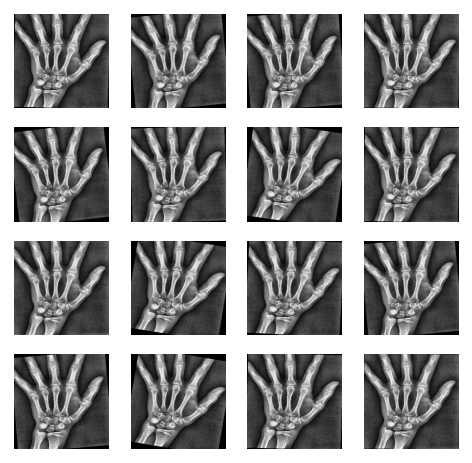

In [11]:
n = 16
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["figure.dpi"] = 144
f = plt.figure()
f.tight_layout()

aug = transforms.Compose(
        [
            transforms.RandomRotation(degrees=10),
        ]
    )


for i in range(n):
    f.add_subplot(4, 4, i+1)
    img = get_img(aug)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis('off')

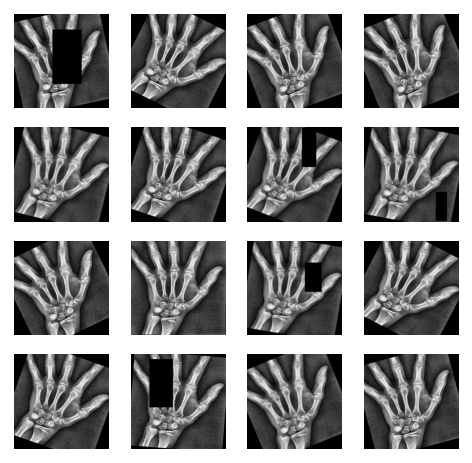

In [35]:
n = 16
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["figure.dpi"] = 144
f = plt.figure()
f.tight_layout()

aug = transforms.Compose(
        [
            transforms.RandomRotation(degrees=30),
            transforms.RandomApply([
                transforms.GaussianBlur(kernel_size=3, sigma=7)
            ], p=0.3),
            transforms.RandomErasing(p=0.4, scale=(0.02, 0.2))

        ]
    )


for i in range(n):
    f.add_subplot(4, 4, i+1)
    img = get_img(aug)
    plt.imshow(img)
    plt.axis('off')

In [34]:
img = cv2.imread(path_to_training_data + "1377.png")
img = process_img(img)

In [77]:
class Patches(nn.Module):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def forward(self, images):
    # 256, 3, 72, 72
    batch = images.size()[0]
    patches = images.unfold(1, 3, 3).unfold(2, self.patch_size, self.patch_size).unfold(3, self.patch_size, self.patch_size)
    patches = patches.squeeze(1)
    patches = patches.resize(batch, 16*16 ,3 * self.patch_size* self.patch_size)
    return patches

/usr/local/lib/python3.9/site-packages/torch/tensor.py:447: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


<Figure size 288x288 with 0 Axes>

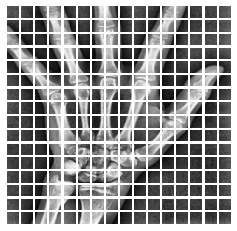

In [78]:
plt.figure(figsize=(4,4))
n = 16
plt.figure(figsize=(4,4))
patches = Patches(patch_size=16)(torch.tensor(img).permute(2,0,1).unsqueeze(0))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = patch.reshape(3, 16, 16).permute(1,2,0)
    plt.imshow(patch_img.numpy())
    plt.axis('off')


In [79]:
content = []
with open('/Users/janbraunsdorff/studienarbeit/log-vit.txt') as f:
    content = f.readlines()
content = [x.strip() for x in content] 

In [80]:
def print_plot(acc, loss, c):
    plt.rcParams["figure.figsize"] = (16, 5)
    plt.rcParams["figure.dpi"] = 256
    f = plt.figure()

    ax = f.add_subplot(1, 3, 1)
    for i in acc:
         plt.plot(i)
    plt.xlabel('Epochen')
    plt.ylabel('Genauigkeit')
    plt.title('Durchnittlicher Fehler in Monaten')
    ax.set_ylim(0, 40)
    plt.legend(['Trainig', 'Validation'])

    ax = f.add_subplot(1, 3, 2)
    for i in loss:
         plt.plot(i)
    plt.xlabel('Epochen')
    plt.ylabel('Fehler')
    plt.title('Durchschnittlicher Fehler der Fehlerfunktion')
    ax.set_ylim(0, 2000)
    plt.legend(['Trainig', 'Validation'])


    ax = f.add_subplot(1, 3, 3)
    for i in c:
        plt.plot(i)
    plt.xlabel('Epochen')
    plt.ylabel('Score (c4*2.0 + c12 + c25*0.5) / Anzahl')
    plt.title('Fehlerklassen')
    plt.legend(['Trainig', 'Validation'])
    ax.set_ylim(0, 8)

    plt.show()

In [81]:
# Epoche: 1 [Done] 00:39 loss: 3487.1731, acc: 45.2324, c1: 6.49% c12: 17.91% c24: 34.85% score: 0.4830 | [Test] loss: 1734.8069, acc: 33.6578, c1: 1e+01% c12: 22.32% c24: 41.12% score: 0.6337 

datapoints = []
for l in content:
    val = l.split(' ')
    train_loss = float(val[5][:-1])
    train_acc = float(val[7][:-1].strip())
    train_c1 = float(val[9][:-1])
    train_c12 = float(val[11][:-1])
    train_c24 = float(val[13][:-1])
    train_score = float(val[15])

    val_loss = float(val[19][:-1])
    val_acc = float(val[21][:-1].strip())
    val_c1 = float(val[23][:-1])
    val_c12 = float(val[25][:-1])
    val_c24 = float(val[27][:-1])
    val_score = float(val[29])    

    datapoints.append((train_loss, train_acc, train_c1, train_c12, train_c24, train_score, val_loss, val_acc, val_c1, val_c12, val_c24, val_score))

datapoints = np.array(datapoints).astype(float)


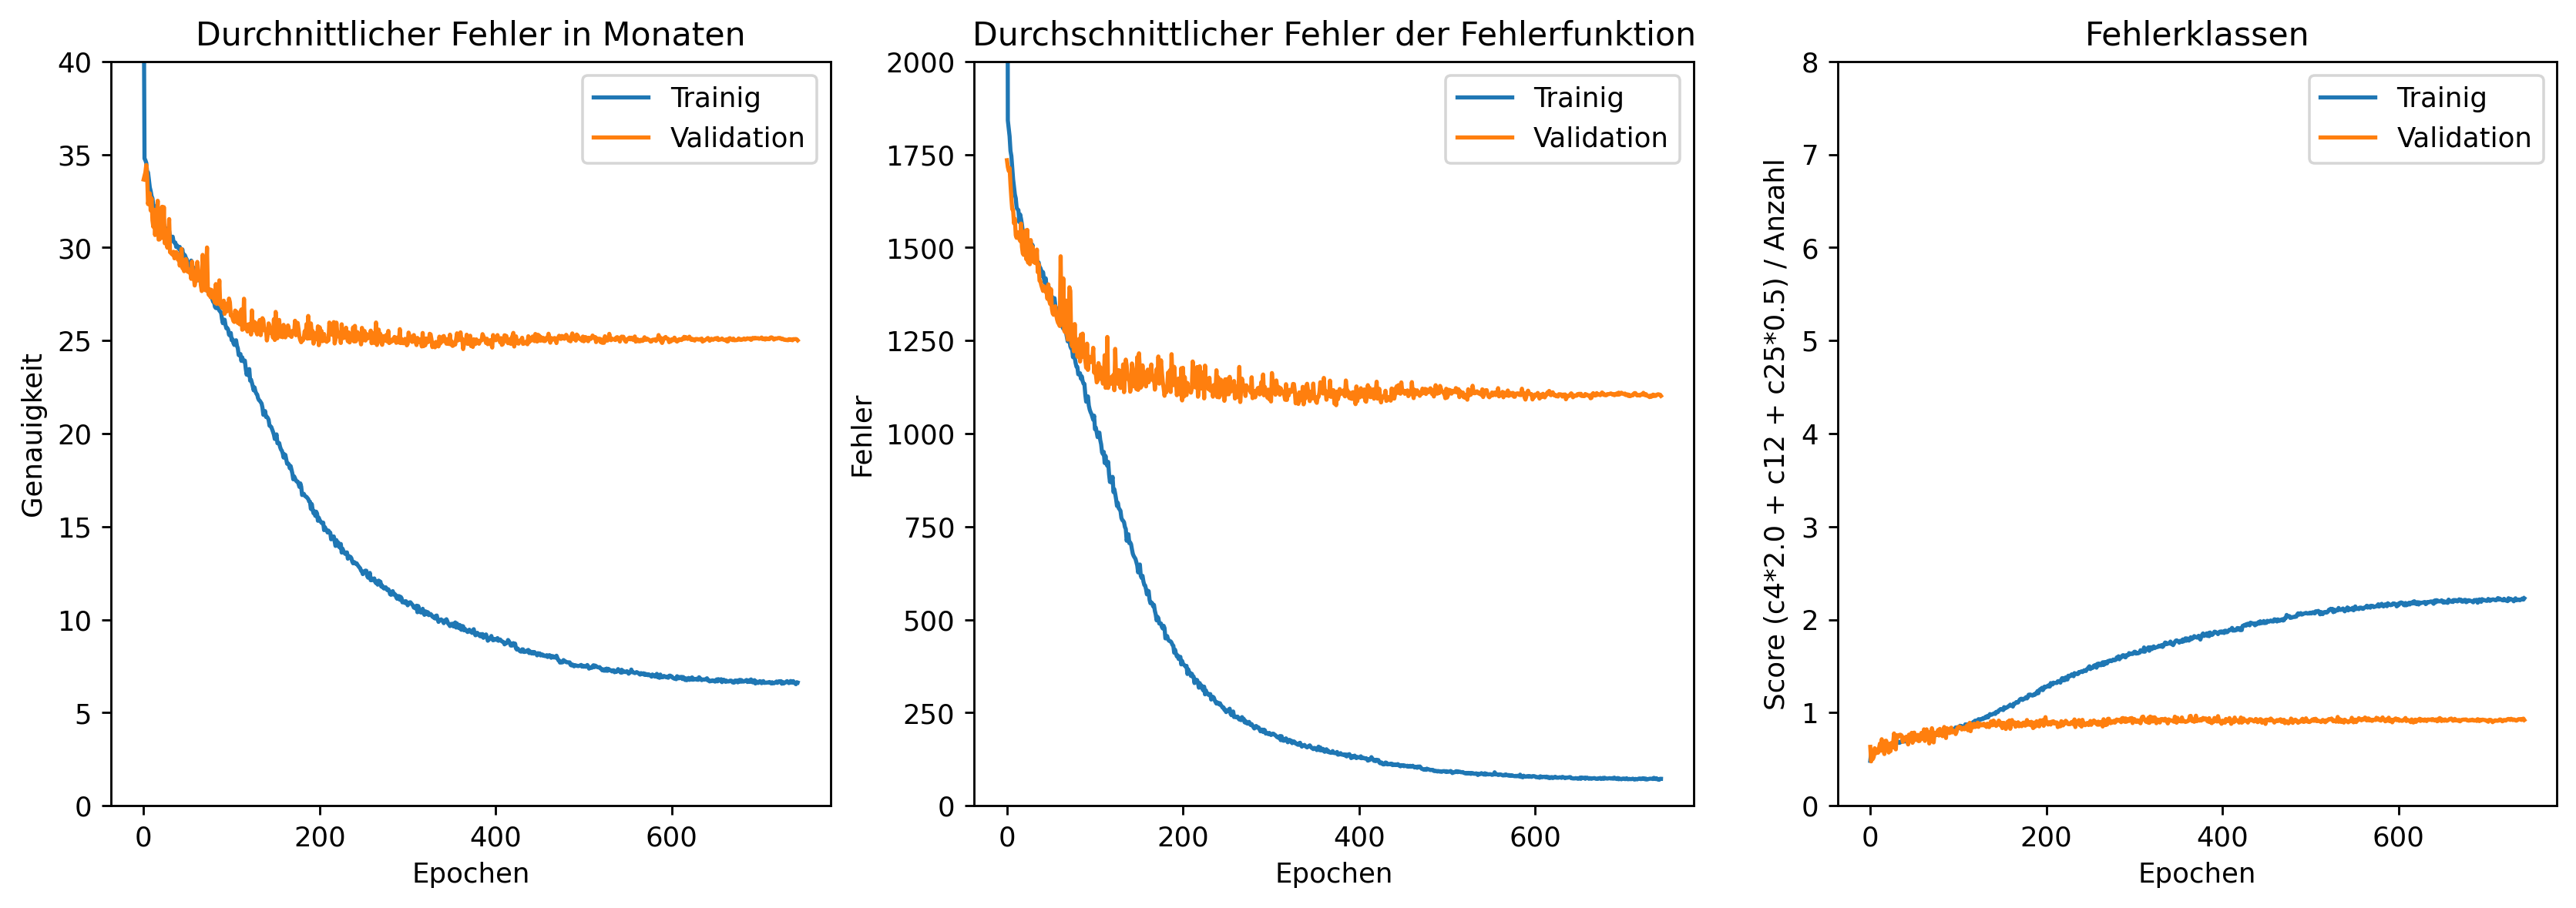

In [82]:

train_losses = [x[0] for x in datapoints]
valid_losses = [x[6] for x in datapoints]

train_acc = [x[1] for x in datapoints]
valid_acc = [x[7] for x in datapoints]

train_score = [x[5] for x in datapoints]
val_score = [x[11] for x in datapoints]


print_plot(
    acc = [train_acc, valid_acc],
    loss = [train_losses, valid_losses],
    c = [train_score, val_score]
)